In [34]:
from rdflib import Graph, Namespace, RDF, RDFS, OWL, Literal
from rdflib.namespace import XSD
import pandas as pd

df = pd.read_csv('polymers_knowledge_graph.csv')

g = Graph()

polymer_kg = Namespace('https://de_novo/polymerkg/')

g.bind('polymerkg', polymer_kg)

SCHEMA = Namespace("http://schema.org/") # SCHEMA
WD   = Namespace("https://www.wikidata.org/entity/") # for entities
WDPROP = Namespace("https://www.wikidata.org/prop/direct/") # for properties
CHEM = Namespace("https://pubchem.ncbi.nlm.nih.gov/") # PUBCHEM

g.bind("schema", SCHEMA)
g.bind("wd", WD)
g.bind("wdprop", WDPROP)
g.bind("chem", CHEM)

#################### CLASSES ####################
chemical_entity_class  = polymer_kg.ChemicalEntity
polymer_class          = polymer_kg.Polymer
monomer_class          = polymer_kg.Monomer
functional_group_class = polymer_kg.FunctionalGroup

g.add((chemical_entity_class, RDF.type, RDFS.Class))
g.add((polymer_class, RDF.type, RDFS.Class))
g.add((monomer_class, RDF.type, RDFS.Class))
g.add((functional_group_class, RDF.type, RDFS.Class))

g.add((polymer_class, RDFS.subClassOf, chemical_entity_class))
g.add((monomer_class, RDFS.subClassOf, chemical_entity_class))
g.add((functional_group_class, RDFS.subClassOf, chemical_entity_class))

#################### PROPERTIES ####################
polymer_name_prop  = RDFS.label
identifier_prop    = polymer_kg.identifier
has_monomer_prop   = polymer_kg.hasMonomer
has_fg_prop        = polymer_kg.hasFunctionalGroup

# Polymer hasMonomer Monomer
g.add((has_monomer_prop, RDFS.domain, polymer_class))
g.add((has_monomer_prop, RDFS.range, monomer_class))

# Polymer hasFunctionalGroup FunctionalGroup
g.add((has_fg_prop, RDFS.domain, polymer_class))
g.add((has_fg_prop, RDFS.range, functional_group_class))

# Polymer identifier (literal string)
g.add((identifier_prop, RDFS.domain, polymer_class))
g.add((identifier_prop, RDFS.range, XSD.string))

# Label property's domain & range (optional for clarity)
g.add((polymer_name_prop, RDFS.domain, chemical_entity_class))
g.add((polymer_name_prop, RDFS.range, XSD.string))

#################### EQUIVALENT CLASSES & PROPERTIES ####################
# EquivalentClass: Polymer ≡ Wikidata Polymer (Q81163)
g.add((polymer_class, OWL.equivalentClass, WD.Q81163))
# EquivalentClass: Monomer ≡ Wikidata Monomer (Q36494)
g.add((monomer_class, OWL.equivalentClass, WD.Q36494))
# EquivalentClass: FunctionalGroup ≡ Wikidata Functional group (Q898262)
g.add((functional_group_class, OWL.equivalentClass, WD.Q898262))

g.add((has_fg_prop, RDF.type, RDF.Property))
g.add((identifier_prop, RDF.type, RDF.Property))
g.add((SCHEMA.identifier, RDF.type, RDF.Property))
g.add((identifier_prop, OWL.equivalentProperty, SCHEMA.identifier))

# hasMonomer = Wikidata(polymerOf) P4600
g.add((has_monomer_prop, RDF.type, RDF.Property))
g.add((WDPROP.P4600, RDF.type, RDF.Property))
g.add((has_monomer_prop, OWL.equivalentProperty, WDPROP.P4600))

g.serialize(destination='polymerkg.ttl', format='turtle')


<Graph identifier=N7d57fa7349204f6496a49683a88e1d6e (<class 'rdflib.graph.Graph'>)>

#

In [35]:
from rdflib import URIRef
from urllib.parse import quote

# Remove any existing polymer instances from previous runs
for s, p, o in list(g.triples((None, RDF.type, polymer_class))):
    g.remove((s, None, None))

for _, row in df.iterrows():
    polymer_label = row['polymer_label']
    polymer_name = str(row['polymer_name']).strip()
    monomers_str = str(row['monomer(s)']).strip() if pd.notna(row['monomer(s)']) else ""
    functional_groups_str = str(row['functional_groups']).strip() if pd.notna(row['functional_groups']) else ""

    # Create polymer instance
    encoded_name = quote(polymer_name, safe='')
    polymer_iri = URIRef(f"http://de_novo/polymerkg/{encoded_name}")

    g.add((polymer_iri, RDF.type, polymer_class))
    g.add((polymer_iri, RDFS.label, Literal(polymer_name, datatype=XSD.string)))

    # Add identifier (polymer_label)
    if pd.notna(polymer_label):
        g.add((polymer_iri, identifier_prop, Literal(str(polymer_label).strip(), datatype=XSD.string)))

    # Process monomers (split by ' + ' for multiple monomers)
    if monomers_str and monomers_str.lower() != 'nan':
        monomer_names = [m.strip() for m in monomers_str.split('+')]
        for monomer_name in monomer_names:
            if monomer_name:
                encoded_monomer = quote(monomer_name, safe='')
                monomer_iri = URIRef(f"http://de_novo/polymerkg/{encoded_monomer}")

                g.add((monomer_iri, RDF.type, monomer_class))
                g.add((monomer_iri, RDFS.label, Literal(monomer_name, datatype=XSD.string)))
                g.add((polymer_iri, has_monomer_prop, monomer_iri))

    # Process functional groups (split by ', ' for multiple groups)
    if functional_groups_str and functional_groups_str.lower() != 'nan':
        fg_names = [fg.strip() for fg in functional_groups_str.split(',')]
        for fg_name in fg_names:
            if fg_name:
                encoded_fg = quote(fg_name, safe='')
                fg_iri = URIRef(f"http://de_novo/polymerkg/{encoded_fg}")

                g.add((fg_iri, RDF.type, functional_group_class))
                g.add((fg_iri, RDFS.label, Literal(fg_name, datatype=XSD.string)))
                g.add((polymer_iri, has_fg_prop, fg_iri))

g.serialize(destination='polymerkg.ttl', format='turtle')
print("Knowledge graph created successfully!")


Knowledge graph created successfully!


C:\Users\berki\AppData\Local\Temp\ipykernel_4600\1012022149.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


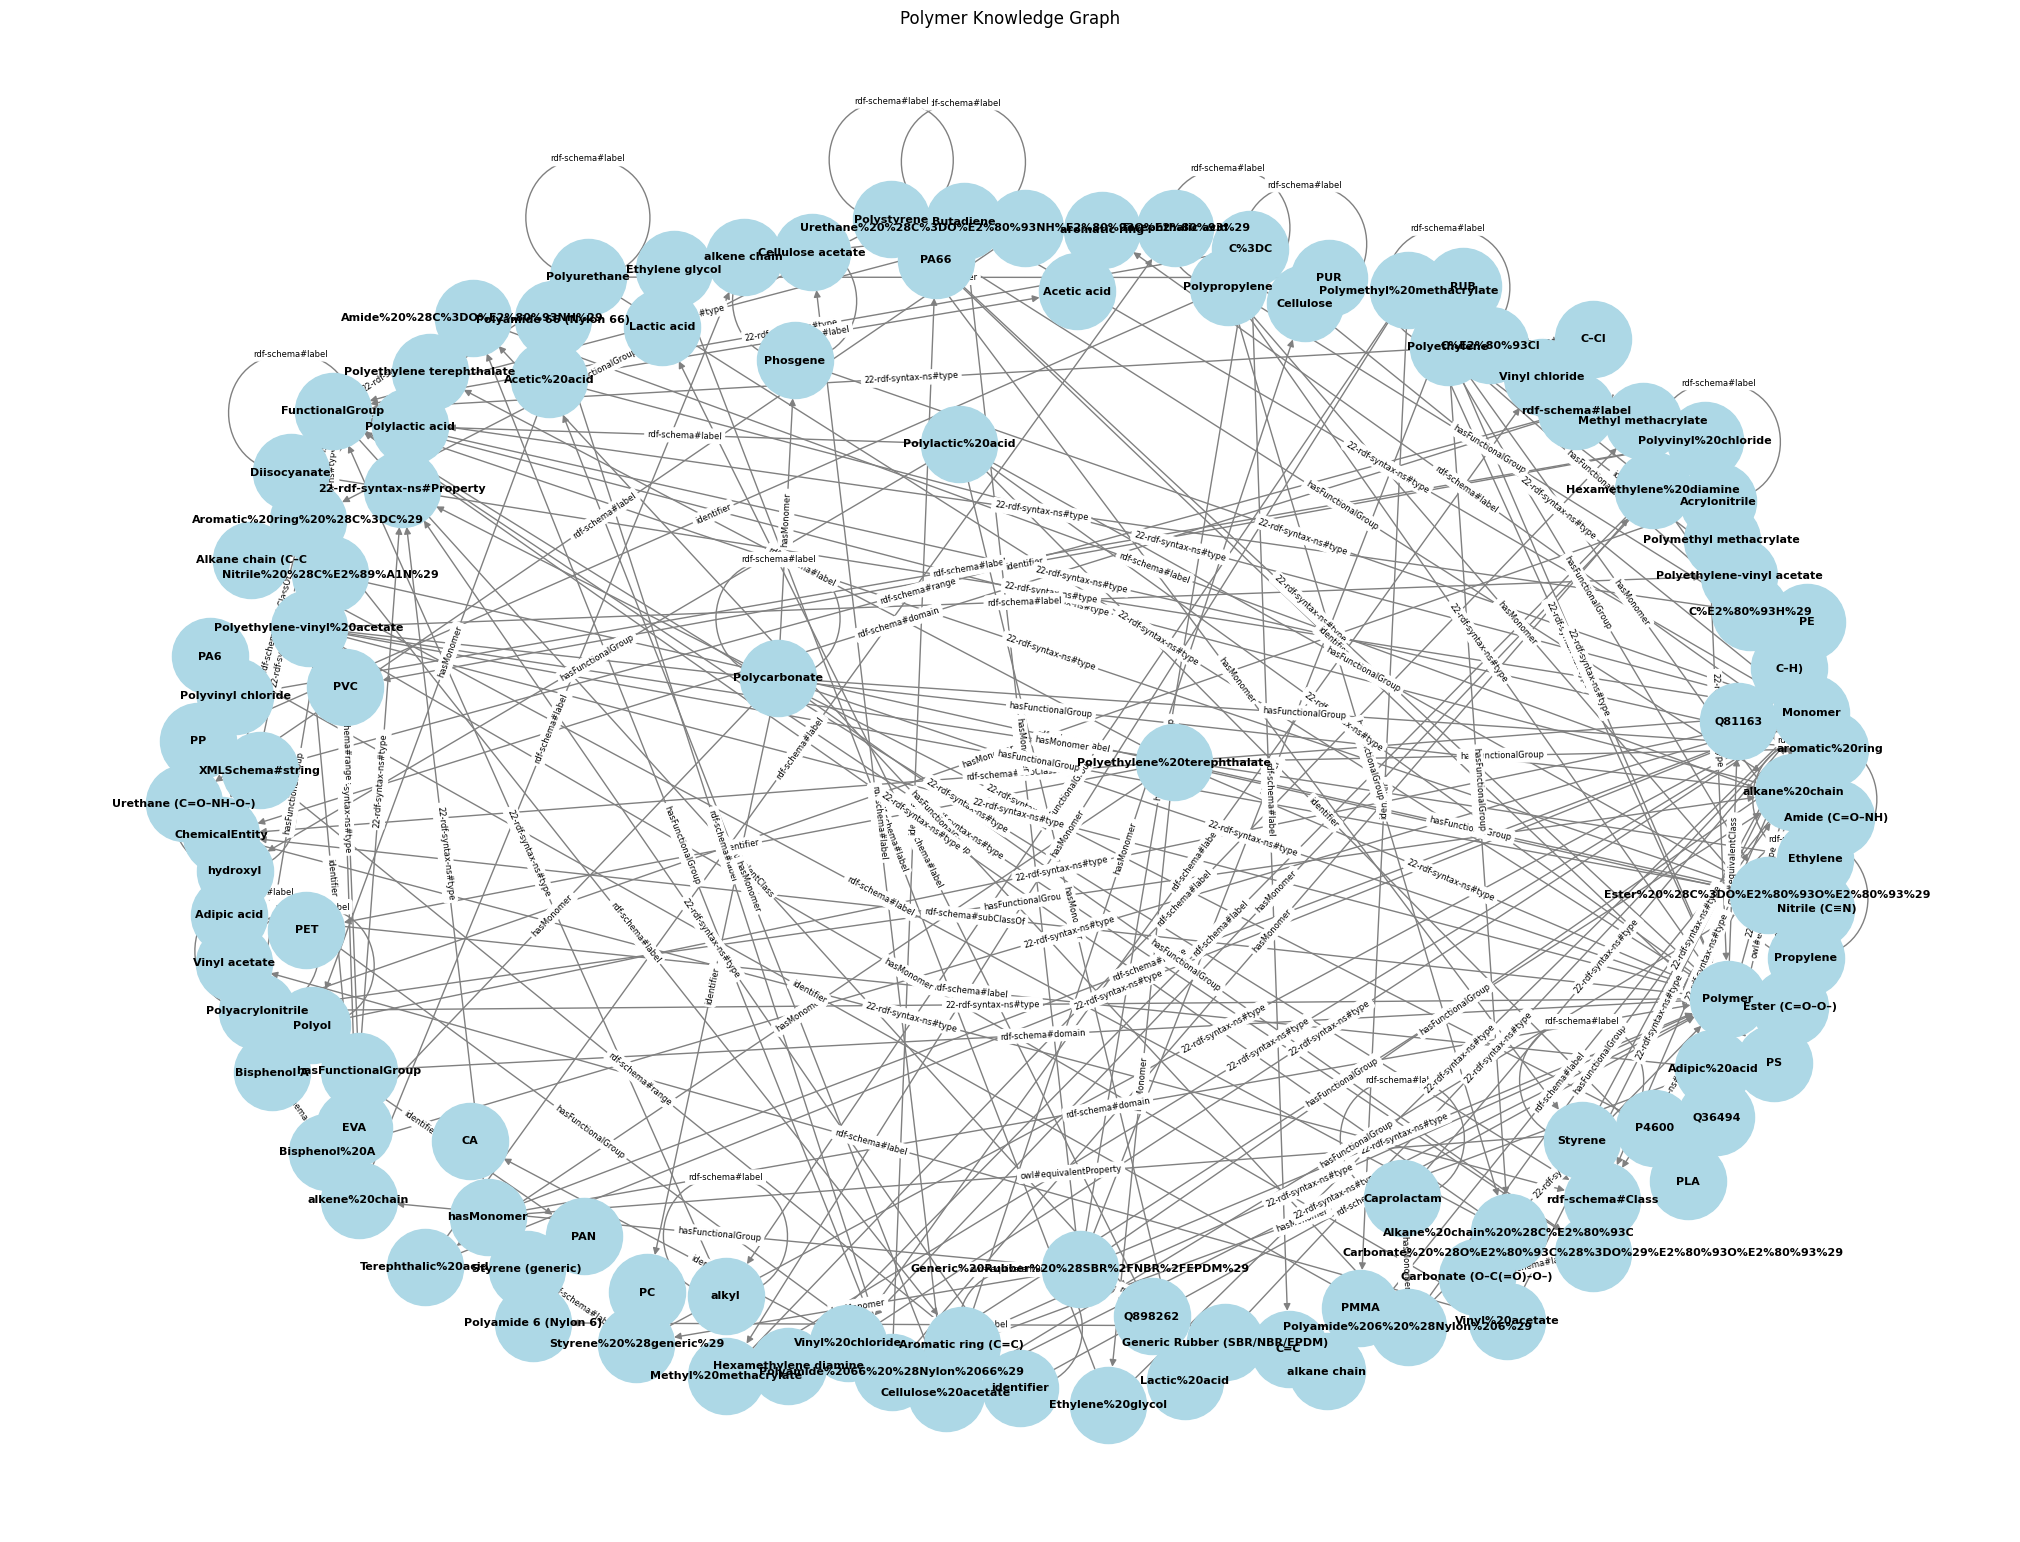

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph


g = Graph()
g.parse('polymerkg.ttl', format='turtle')

G = nx.DiGraph()

for s, p, o in g:
    s_label = str(s).split('/')[-1]
    p_label = str(p).split('/')[-1]
    o_label = str(o).split('/')[-1] if not isinstance(o, Literal) else str(o)

    G.add_edge(s_label, o_label, label=p_label)


plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=2, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=8, font_weight='bold',
        arrows=True, edge_color='gray')

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

plt.title("Polymer Knowledge Graph")
plt.tight_layout()
plt.savefig('polymer_kg_visualization.png', dpi=300, bbox_inches='tight')
plt.show()